# 🔎🗣️ Hands-On: Automatic Speech Recognition Pipelines

<p align="right">
<i>── by Jérôme Louradour,<br>expert in AI, Deep Learning, NLP and Speech/Audio Processing.<br>(02/2025)</i>
<br>
</p>

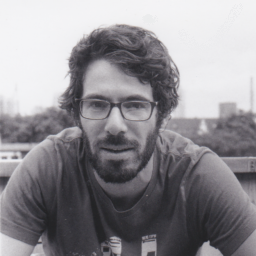 

| | <p align="center">**Dr. Jérôme Louradour**<br><br>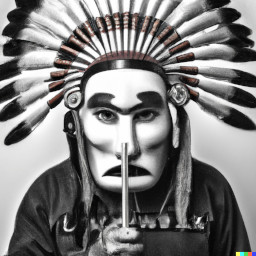</p> | <p align="center">**OpenLLM France ／ Europe**<br><br>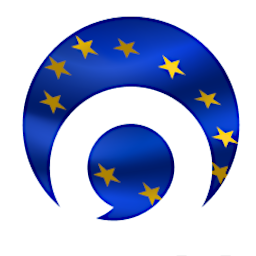</p> | <p align="center">**LINAGORA ／ LinTO**<br><br>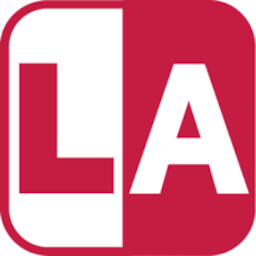</p> |
|---|---|---|---|
|  **LinkedIn** | <p align="right">[linkedin.com/in/jeronymous](https://www.linkedin.com/in/jeronymous/)</p> | <p align="right">[linkedin.com/company/openllm-france](https://www.linkedin.com/company/openllm-france)</p> | <p align="right">[linkedin.com/company/linagora](https://www.linkedin.com/company/linagora)</p> |
|  **GitHub** | <p align="right">[github.com/Jeronymous](https://github.com/Jeronymous)</p> | <p align="right">[github.com/OpenLLM-France](https://github.com/OpenLLM-France)</p> | <p align="right">[github.com/linagora-labs](https://github.com/linagora-labs)<br>[github.com/linto-ai](https://github.com/linto-ai)</p> |
| 🤗 **HuggingFace** | <p align="right">[huggingface.co/Jeronymous](https://huggingface.co/Jeronymous)</p> | <p align="right">[huggingface.co/OpenLLM-France](https://huggingface.co/OpenLLM-France)</p> | <p align="right">[huggingface.co/linagora](https://huggingface.co/linagora)</p> |
|  **Discord** | <p align="right">[jeronymous](https://discord.com/channels/Jeronymous)</p> | <p align="right">[OpenLLM Europe](https://discord.gg/VFJxQnqrEU)</p> | <p align="right">[LinTO](https://discord.gg/RZSnfqMjSU)</p> |
| **🌐** | <p align="right">[www.youtube.com/@jerhum6999](https://www.youtube.com/@jerhum6999)</p> | <p align="right">[www.openllm-france.fr](https://www.openllm-france.fr)</p> | <p align="right">[linagora.com](https://linagora.com)<br>[labs.linagora.com](https://labs.linagora.com)<br>[doc.linto.ai](https://doc.linto.ai)</p> |


**Table of Contents**
- [📖 Introduction](#intro)
- [🎙️ Load Audio Files](#load)
- [🎞️ Voice Activity Detection (VAD)](#vad)
- [🗣️ Speaker Diarization](#diarization)
- [🪪 Speaker Identification](#identification)
- [📝 Automatic Speech Recognition / Speech-To-Text (ASR / STT)](#asr)
- [🔊 Text-To-Speech (TTS)](#tts)
- [📦 All Together Now](#conclusion)

<h2 id="intro">📖 Introduction</h2>

<h2 id="load">🎙️ Load Audio Files</h2>

Define some helper functions to load audio files (or chunks of audio),
* from several audio formats (WAV, MP3, FLAC, OPUS, ...)
* into several array formats (numpy arrays / torch tensors / bytes for online streaming)

...with a fixed sample rate (e.g. 16 kHz) and a fixed number of channels (e.g. mono).

Loading audio can be the bottleneck.<br>
For instance, if a small chunk must be loaded from a huge audio file, it needs to uncompress all data before the chunk.
Which can be a nogo to train.

From https://github.com/faroit/python_audio_loading_benchmark:<br>
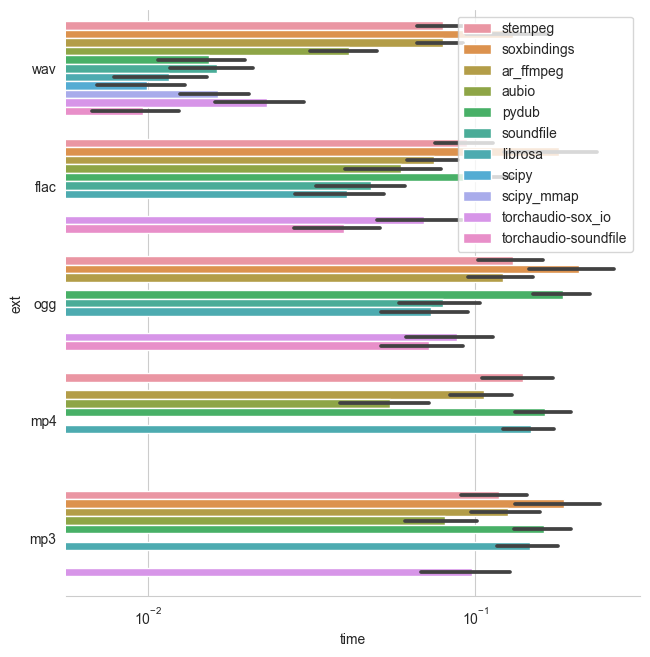

In [1]:
import sys, os
import librosa
import soxbindings as sox
import torchaudio

import numpy as np
import torch

AUDIO_EXTENSIONS = [".wav", ".mp3", ".flac", ".opus"]

def load_audio(path, start = None, end = None, sample_rate = 16_000, mono = True, return_format = 'array'):
    """ 
    Load an audio file and return the data.

    Parameters
    ----------
    path: str
        path to the audio file
    start: float
        start time in seconds. If None, the file will be loaded from the beginning.
    end: float
        end time in seconds. If None the file will be loaded until the end.
    sample_rate: int
        destination sampling rate in Hz
    mono: bool
        if True, convert to mono
    return_format: str (default: 'array')
        'array': numpy.array
        'torch': torch.Tensor
        'bytes': bytes
    
    verbose: bool
        if True, print the steps
    """
    assert return_format in ['array', 'torch', 'bytes']
    if not os.path.isfile(path):
        # Because soxbindings does not indicate the filename if the file does not exist
        raise RuntimeError("File not found: %s" % path)
    # Test if we have read permission on the file
    elif not os.access(path, os.R_OK):
        # os.system("chmod a+r %s" % path)
        raise RuntimeError("Missing reading permission for: %s" % path)
    
    must_cut = start or end

    if return_format == 'torch' and not must_cut:
        if must_cut: # This path is super slow and has been disabled
            start = float(start if start else 0)
            sr = torchaudio.info(path).sample_rate
            offset = int(start * sr)
            num_frames = -1
            if end:
                end = float(end)
                num_frames = int((end - start) * sr)
            audio, sr = torchaudio.load(path, frame_offset=offset, num_frames=num_frames)
        else:
            audio, sr = torchaudio.load(path)

    else:

        with suppress_stderr():
            # stderr could print these harmless warnings:
            # 1/ Could occur with sox.read
            #   mp3: MAD lost sync
            #   mp3: recoverable MAD error
            # 2/ Could occur with sox.get_info
            #   wav: wave header missing extended part of fmt chunk
            if must_cut: # is not None:
                start = float(start if start else 0)
                sr = sox.get_info(path)[0].rate
                offset = int(start * sr)
                nframes = 0
                if end: # is not None:
                    end = float(end)
                    nframes = int((end - start) * sr)
                audio, sr = sox.read(path, offset = offset, nframes = nframes)
            else:
                audio, sr = sox.read(path)

        audio = np.float32(audio)

    audio = conform_audio(audio, sr, sample_rate=sample_rate, mono=mono, return_format=return_format)

    if sample_rate is None:
        return (audio, sr)
    return audio


class suppress_stderr(object):
    """
    A context manager for doing a "deep suppression" of stdout and stderr in Python, i.e. will suppress all print, even if the print originates in a compiled C/Fortran sub-function.
    """
    def __enter__(self):
        self.errnull_file = open(os.devnull, 'w')
        self.old_stderr_fileno_undup = sys.stderr.fileno()
        self.old_stderr_fileno = os.dup(sys.stderr.fileno())
        self.old_stderr = sys.stderr
        os.dup2(self.errnull_file.fileno(), self.old_stderr_fileno_undup)
        sys.stderr = self.errnull_file
        return self

    def __exit__(self, *_):
        sys.stderr = self.old_stderr
        os.dup2(self.old_stderr_fileno, self.old_stderr_fileno_undup)
        os.close(self.old_stderr_fileno)
        self.errnull_file.close()


def conform_audio(audio, sr, sample_rate=16_000, mono=True, return_format='array'):
    """
    Conform the audio to the desired format (mono channel, fixed frequency -- 16kHz)
    """
    if mono:
        if len(audio.shape) == 1:
            pass
        elif len(audio.shape) > 2:
            raise RuntimeError("Audio with more than 2 dimensions not supported")
        elif min(audio.shape) == 1:
            audio = audio.reshape(audio.shape[0] * audio.shape[1])
        else:
            if isinstance(audio, torch.Tensor):
                audio = audio.numpy()
            else:
                audio = audio.transpose()
            audio = librosa.to_mono(audio)
    if sample_rate is not None and sr != sample_rate:
        if not isinstance(audio, torch.Tensor):
            audio = torch.Tensor(audio)
        
        # # We don't use librosa here because there is a problem with multi-threading
        # audio = librosa.resample(audio, orig_sr = sr, target_sr = sample_rate)
        
        audio = torchaudio.transforms.Resample(sr, sample_rate)(torch.Tensor(audio))
    
    if return_format == "torch" and not isinstance(audio, torch.Tensor):
        audio = torch.Tensor(audio)
    elif return_format != "torch":
        if isinstance(audio, torch.Tensor):
            audio = audio.numpy()
        elif isinstance(audio, list):
            audio = np.array(audio, dtype=np.float32)
        if return_format == "bytes":
            audio = array_to_bytes(audio)

    return audio

def array_to_bytes(audio):
    return (audio * 32768).astype(np.int16).tobytes()

Let's load some sample audio files to work with, and visualize the audio waveforms.

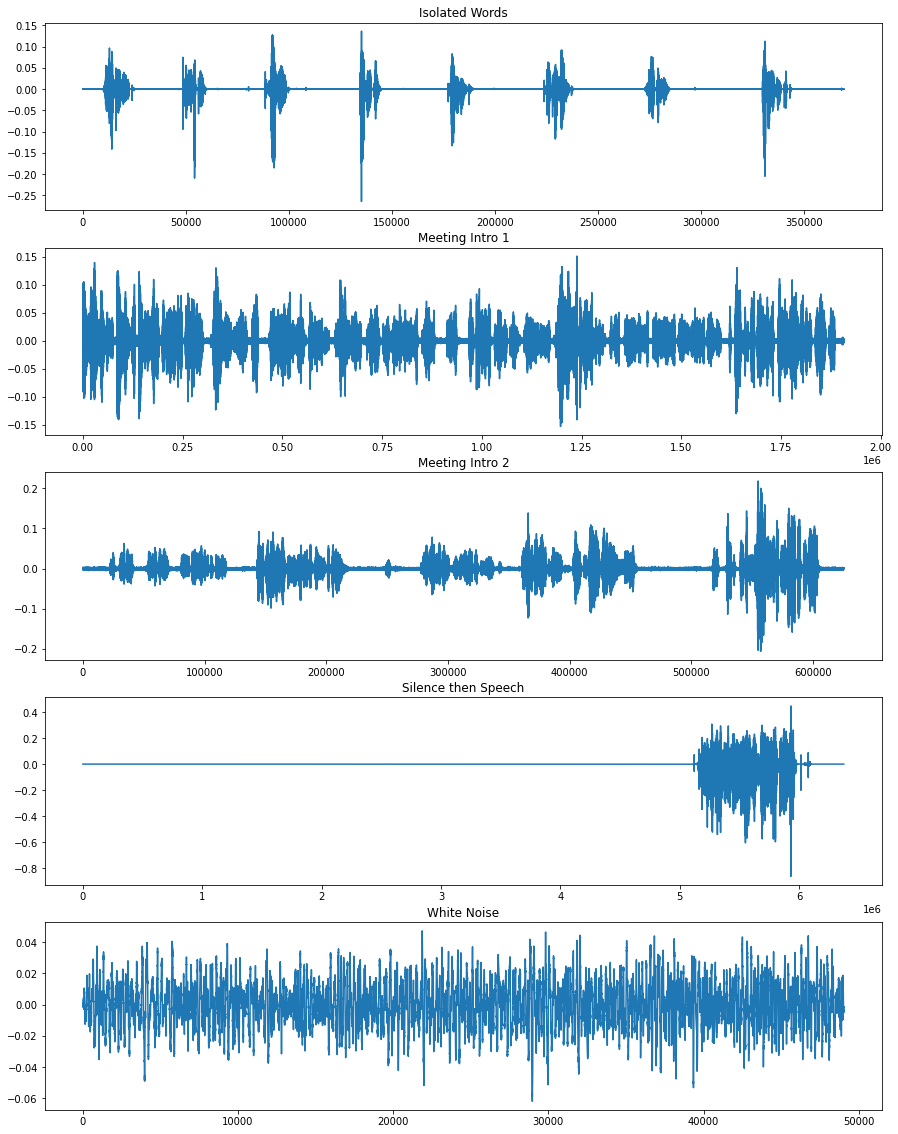

In [2]:
import matplotlib.pyplot as plt

# Define paths to sample audio files for demo

AUDIO_FOLDER = os.path.join("data", "audio")
assert os.path.isdir(AUDIO_FOLDER), f"Cannot find audio folder: {AUDIO_FOLDER}"
AUDIO_FILES = {}
for filename in os.listdir(AUDIO_FOLDER):
    name, ext = os.path.splitext(filename)
    if ext in AUDIO_EXTENSIONS:
        AUDIO_FILES[name] = os.path.join(AUDIO_FOLDER, filename)

# Load file contents and plot audio waveforms
n = len(AUDIO_FILES)
plt.subplots(n, 1, figsize=(15, 4 * len(AUDIO_FILES)))
for i, (k, fn) in enumerate(AUDIO_FILES.items()):
    audio = load_audio(fn)    
    plt.subplot(n, 1, i + 1)    
    plt.plot(audio)
    plt.title(k)

plt.show()


<h2 id="vad">🎞️ Voice Activity Detection (VAD)</h2>

VAD is a pre-processing step to detect speech segments in an audio signal.

It is an important step in ASR pipelines
* to reduce the amount of audio data to process, and
* to improve the accuracy of the speech recognition model (as Artifical Neural Nets may hallucinate words in non-speech segments).

There are several technologies to perform VAD:
1. **Energy-based VAD**: based on the energy of the audio signal, with heuristics, adaptative thresholds, ...
2. **Machine Learning based VAD**: based on a Neural Net or ML statistical model trained to classify speech vs non-speech segments.

It is in general easy to generalize VAD methods from the offline setting (access to the whole audio) to the online setting (streaming audio chunks).\
Because most of methods classify audio chunks independently or in an auto-regressive way (prediction based on previous chunks).

VAD methods <br>
`├──` 🧠 Neural Net based (audio frame classification)<br>
`|...├──` SILERO <br>
`|...└──` PyAnnnote <br>
`└──` 📈 Energy based (heuristics, adaptive thresholds, ...)<br>
`....├──` WebRTC <br>
`....└──` Auditok <br>

Define helpers to run VAD on audio chunks, and visualize the VAD results on some audio files:

Using cache found in /home/jlouradour/.cache/torch/hub/snakers4_silero-vad_master


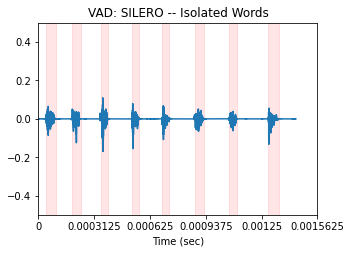

Lightning automatically upgraded your loaded checkpoint from v1.1.3 to v2.4.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../../../../../../home/jlouradour/.cache/torch/pyannote/models--pyannote--segmentation/snapshots/059e96f964841d40f1a5e755bb7223f76666bba4/pytorch_model.bin`


Model was trained with pyannote.audio 0.0.1, yours is 3.3.2. Bad things might happen unless you revert pyannote.audio to 0.x.
Model was trained with torch 1.7.1, yours is 2.3.0+cu121. Bad things might happen unless you revert torch to 1.x.


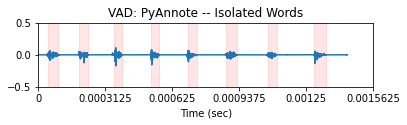

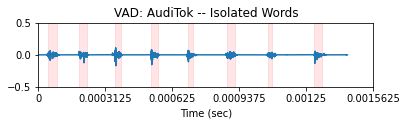

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

import onnxruntime
from pyannote.audio import Pipeline
import auditok

_silero_vad_model = None
_silero_get_speech_ts = None
_pyannote_vad_pipeline = None


def get_vad_segments(audio, sample_rate=16_000,
                     method="auditok",
                     min_speech_duration=0.25,
                     min_silence_duration=0.1,
                     dilatation=0,
                     use_samples=False,
                     ):
    """
    Get speech segments from audio file using Silero VAD
    parameters:
        audio: str or torch.Tensor
            path to audio file or audio data
        method: str
            method to use for VAD (silero, pyannote, auditok)
        sample_rate: int
            sample rate of audio data (in case it is not a file)
        min_speech_duration: float
            minimum speech duration (seconds)
        min_silence_duration: float
            minimum silence duration (seconds)
        dilatation: float
            dilatation of speech segments (seconds)
        use_samples: bool
            if True, return start and end in samples instead of seconds
    """
    global _silero_vad_model, _silero_get_speech_ts, _pyannote_vad_pipeline

    method = method.lower()
    format = "torch"
    if method in ["silero"]:
        sample_rate_target = 16000
    elif method in ["pyannote", "auditok"]:
        sample_rate_target = None
    else:
        raise ValueError(f"Unknown VAD method: {method}")
    if method == "auditok":
        format = "array"

    if isinstance(audio, str):
        (audio, sample_rate) = load_audio(audio, sample_rate=None, return_format=format)
    audio = conform_audio(audio, sample_rate, sample_rate=sample_rate_target, return_format=format)
    
    if sample_rate_target is None:
        sample_rate_target = sample_rate

    if method == "silero":
        if _silero_vad_model is None:
            # Remove warning "Removing initializer 'XXX'. It is not used by any node and should be removed from the model."
            onnxruntime.set_default_logger_severity(3)
            _silero_vad_model, utils = torch.hub.load(repo_or_dir="snakers4/silero-vad", model="silero_vad", onnx=True)
            _silero_get_speech_ts = utils[0]

        # Cheap normalization of the amplitude
        audio = audio / max(0.1, audio.abs().max())

        segments = _silero_get_speech_ts(audio, _silero_vad_model,
                                        min_speech_duration_ms=round(min_speech_duration * 1000),
                                        min_silence_duration_ms=round(min_silence_duration * 1000),
                                        return_seconds=False,
        )

    elif method == "pyannote":
        if _pyannote_vad_pipeline is None:
            _pyannote_vad_pipeline = Pipeline.from_pretrained("pyannote/voice-activity-detection",
                                                             use_auth_token="hf_XXX"
                                                             )

        _pyannote_vad_pipeline.min_duration_on = min_speech_duration  # 0.05537587440407595
        _pyannote_vad_pipeline.min_duration_off = min_silence_duration  # 0.09791355693027545

        pyannote_segments = _pyannote_vad_pipeline(
            {"waveform": audio.unsqueeze(0), "sample_rate": sample_rate_target})

        segments = []
        for speech_turn in pyannote_segments.get_timeline().support():
            segments.append({"start": speech_turn.start * sample_rate_target,
                            "end": speech_turn.end * sample_rate_target})
            
    elif method == "auditok":
        data = (audio * 32767).astype(np.int16).tobytes()

        segments = auditok.split(
            data,
            sampling_rate=sample_rate_target, # sampling frequency in Hz
            channels=1,                       # number of channels
            sample_width=2,                   # number of bytes per sample
            min_dur=min_speech_duration,      # minimum duration of a valid audio event in seconds
            max_dur=len(audio)/sample_rate_target, # maximum duration of an event
            max_silence=min_silence_duration, # maximum duration of tolerated continuous silence within an event
            energy_threshold=50,
            drop_trailing_silence=True,
        )

        if auditok.__version__ >= "0.3.0":
            def auditok_segment_to_dict(s):
                return {"start": s.start * sample_rate, "end": s.end * sample_rate}
        else:
            def auditok_segment_to_dict(s):
                return {"start": s._meta.start * sample_rate, "end": s._meta.end * sample_rate}

        segments = [auditok_segment_to_dict(s) for s in segments]

    if dilatation > 0:
        dilatation = round(dilatation * sample_rate_target)
        new_segments = []
        for seg in segments:
            new_seg = {
                "start": max(0, seg["start"] - dilatation),
                "end": min(len(audio), seg["end"] + dilatation)
            }
            if len(new_segments) > 0 and new_segments[-1]["end"] >= new_seg["start"]:
                new_segments[-1]["end"] = new_seg["end"]
            else:
                new_segments.append(new_seg)
        segments = new_segments

    ratio = sample_rate / sample_rate_target if use_samples else 1 / sample_rate_target

    if ratio != 1.:
        for seg in segments:
            seg["start"] *= ratio
            seg["end"] *= ratio
    if use_samples:
        for seg in segments:
            seg["start"] = round(seg["start"])
            seg["end"] = round(seg["end"])

    return segments


def remove_non_speech(audio,
                      sample_rate=16_000,
                      use_sample=False,
                      policy_on_empty="none",
                      **kwargs,
                      ):
    """
    Remove non-speech segments from audio (using Silero or Auditok, see get_vad_segments),
    glue the speech segments together and return the result along with
    a function to convert timestamps from the new audio to the original audio.

    parameters:
        audio: str or torch.Tensor
            audio data
        sample_rate: int
            sample rate of audio data
        policy_on_empty: str (default: 'full')
            policy when no speech is detected:
            'full':  return the full audio.
            'empty': return an empty array.
            'none':  return None.
            'fail':  raise an exception.
    """
    if isinstance(audio, str):
        (audio, sample_rate) = load_audio(audio, sample_rate=None,
                                          return_format="torch", mono=False)

    segments = get_vad_segments(
        audio, sample_rate=sample_rate,
        use_samples=True,
        **kwargs,
    )

    segments = [(seg["start"], seg["end"]) for seg in segments]
    if len(segments) == 0:
        if policy_on_empty == "full":
            segments = [(0, audio.shape[-1])]
            audio_speech = audio
        elif policy_on_empty == "empty":
            audio_speech = audio.new_zeros(audio.shape)
        elif policy_on_empty == "none":
            audio_speech = None
        elif policy_on_empty == "fail":
            raise ValueError(f"No speech detected on audio of shape {audio.shape}")
        else:
            raise ValueError(f"Unknown policy_on_empty: {policy_on_empty}")
    else:
        if not isinstance(audio, torch.Tensor): 
            audio_speech = np.concatenate([audio[..., s:e] for s, e in segments], axis=-1)
        else:
            audio_speech = torch.cat([audio[..., s:e] for s, e in segments], dim=-1)
        
        if len(audio.shape) == 1:
            audio_speech = audio_speech.reshape(-1)


    if not use_sample:
        segments = [(float(s)/sample_rate, float(e)/sample_rate)
                    for s, e in segments]

    return audio_speech, lambda t, t2 = None: convert_timestamps(segments, t, t2)


def plot_vad(
        audio,
        segments,
        sample_rate=16_000,
        max_num_samples=10_000,
        policy_on_empty='none',
        scale_signal=True,
        title=None,
        plot_final=False,
        **kwargs
    ):
    """
    Plot audio with non-speech segments highlighted in red and audio without non-speech segments.
    
    parameters:
        audio: torch.Tensor
            audio data
        segments: list of tuple (start, end) corresponding to non-speech segments in original audio
        sample_rate: int (default: 16_000)
            sample rate of audio data
        max_num_samples: int (default: 10_000)
            maximum number of samples to plot
        policy_on_empty: str (default: 'none')
            policy when no speech is detected (see help for remove_non_speech function)
        title: str
            title of the plot
        kwargs: dict
            additional arguments to pass to plt.plot
    """

    def set_xticks():
        xmin, xmax = plt.xlim()
        xmin = 0
        plt.xlim(xmin, xmax)
        ts, _ = plt.xticks()
        step_sec = float(ts[1] - ts[0])
        use_ms = step_sec < 1
        if use_ms:
            tlabels =  [t * 1000 / sample_rate for t in ts]
            plt.xticks(ts, [str(int(t)) if round(t)==t else "{t:.3f}" for t in tlabels])
            plt.xlabel("Time (ms)")
        else:
            tlabels =  [t / sample_rate for t in ts]
            plt.xticks(ts, [f"{int(t) if round(t)==t else t}" for t in tlabels])
            plt.xlabel("Time (sec)")

    # Plot original audio, spotting non-speech segments
    if plot_final:
        plt.subplot(1, 2, 1)
    max_num_samples = min(max_num_samples, audio.shape[-1])
    step = (audio.shape[-1] // max_num_samples) + 1
    times = [i*step/sample_rate for i in range((audio.shape[-1]-1) // step + 1)]
    audio_mono = audio.mean(dim=0) if len(audio.shape) > 1 else audio
    plt.plot(times, audio_mono[::step])
    if scale_signal:
        plt.ylim(-0.5, 0.5)
    for s in segments:
        plt.axvspan(s["start"], s["end"], color='red', alpha=0.1)
    set_xticks()

    # Plot audio without non-speech segments
    if plot_final:
        plt.title("Original audio with speech segments highlighted")

        plt.subplot(1, 2, 2)
        audio_speech, convert_timestamps_func = remove_non_speech(audio, sample_rate=sample_rate, policy_on_empty=policy_on_empty)
        audio_speech_mono = audio_speech.mean(dim=0) if len(audio_speech.shape) > 1 else audio_speech
        step = (audio_speech_mono.shape[-1] // max_num_samples) + 1
        times = [i*step/sample_rate for i in range((audio_speech_mono.shape[-1]-1) // step + 1)]
        plt.plot(times, audio_speech_mono[::step], **kwargs)
        if scale_signal:
            plt.ylim(-0.5, 0.5)
        set_xticks()
        plt.title("Audio without non-speech segments")

    if title:
        if plot_final:
            plt.suptitle(title)
        else:
            plt.title(title)
    
    plt.show()

def convert_timestamps(segments, t, t2=None):
    """
    Convert timestamp from audio without non-speech segments to original audio (with non-speech segments)

    parameters:
        segments: list of tuple (start, end) corresponding to non-speech segments in original audio
        t: timestamp to convert
        t2: second timestamp to convert (optional), when the two timestamps should be in the same segment
    """
    assert len(segments)
    ioffset = 0  # Input offset
    ooffset = 0  # Output offset
    ipreviousend = 0
    result = []
    for istart, iend in segments:
        ostart = ooffset
        oend = ostart + (iend - istart)
        ooffset = oend
        ioffset += istart - ipreviousend
        ipreviousend = iend
        t_in = t <= oend
        t2_in = t_in if t2 is None else t2 <= oend
        if t_in or t2_in:
            result.append([
                max(istart, min(iend, ioffset + t)),
                max(istart, min(iend, ioffset + t2)) if t2 is not None else None
            ])
            if t_in and t2_in:
                break
    if not len(result):
        result.append(
            [ioffset + t, ioffset + t2 if t2 is not None else None]
        )

    if len(result) > 1:
        # Minimize difference between durations
        result = sorted(result, key=lambda x: abs(abs(t2-t) - abs(x[1]-x[0])))
    result = result[0]
    if t2 is None:
        result = result[0]
    return result


###############################################################
# Test VAD on some audio samples, visualizing the VAD results #
###############################################################

max_audios = 3
METHODS = ["SILERO", "PyAnnote", "AudiTok"]
for i, (name, audio_file) in enumerate(AUDIO_FILES.items()):
    if i >= max_audios:
        break

    plt.figure(figsize=(5, 4 * len(METHODS)))
    for imethod, method in enumerate(METHODS):

        kwargs = dict(
            method=method.lower(),
            min_speech_duration=0.25,
            min_silence_duration=0.1,
            dilatation=0,
        )

        audio = load_audio(audio_file)
        speech_segments = get_vad_segments(audio, **kwargs)

        # Plot results
        plt.subplot(len(METHODS), 1, imethod + 1)
        plot_vad(
            audio,
            speech_segments,
            policy_on_empty='none',
            title=f"VAD: {method} -- {name}",
        )
    break


<h2 id="diarization">🗣️ Speaker Diarization</h2>

<h2 id="identification">🪪 Speaker Identification</h2>

<h2 id="asr">📝 Automatic Speech Recognition / Speech-To-Text (ASR / STT)</h2>

<h2 id="tts">🔊 Text-To-Speech (TTS)</h2>

<h2 id="conclusion">📦 All Together Now</h2>